# Predicting vaccination rates in the US


## Models used:

- `Regularised regression`
- `Random Forest regression`
- `Gradient Boosted Decision Trees`
- `SVM`?
- `NN`?


### Normalisation:

- `Regularised regression`



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR


from sklearn import preprocessing

In [3]:
base = os.path.split(os.getcwd())[0]
dd = base + '/data/'

In [4]:
df_all = pd.read_csv(dd + 'data_after_imputation.csv')

In [5]:
df_all.shape

(3108, 34)

In [6]:
df_all.columns

Index(['fips', 'state', 'county', 'state_abb', 'pop_full_12plus_per',
       'pop_full_18plus_per', 'pop_full_65plus_per', 'cases_prop',
       'death_prop', 'hesitant_unsure', 'SVI', 'SVI_cat', 'CVAC', 'CVAC_cat',
       'Hispanic (%)', 'non-Hispanic American Indian/Alaska Native (%)',
       'non-Hispanic Asian (%)', 'non-Hispanic Black (%)',
       'non-Hispanic Native Hawaiian/Pacific Islander (%)',
       'non-Hispanic White (%)', 'noHealthInsurance', 'noHighSchool',
       'Poverty', 'logPopDensity', 'Urban_rural_code', 'PrematureDeath',
       'Smoking', 'anycondition_prevalence', 'per_dem', 'per_voted', 'Testing',
       'Traffic', 'DaytimePopDensity', 'ToxPi Score'],
      dtype='object')

<Figure size 2016x1728 with 0 Axes>

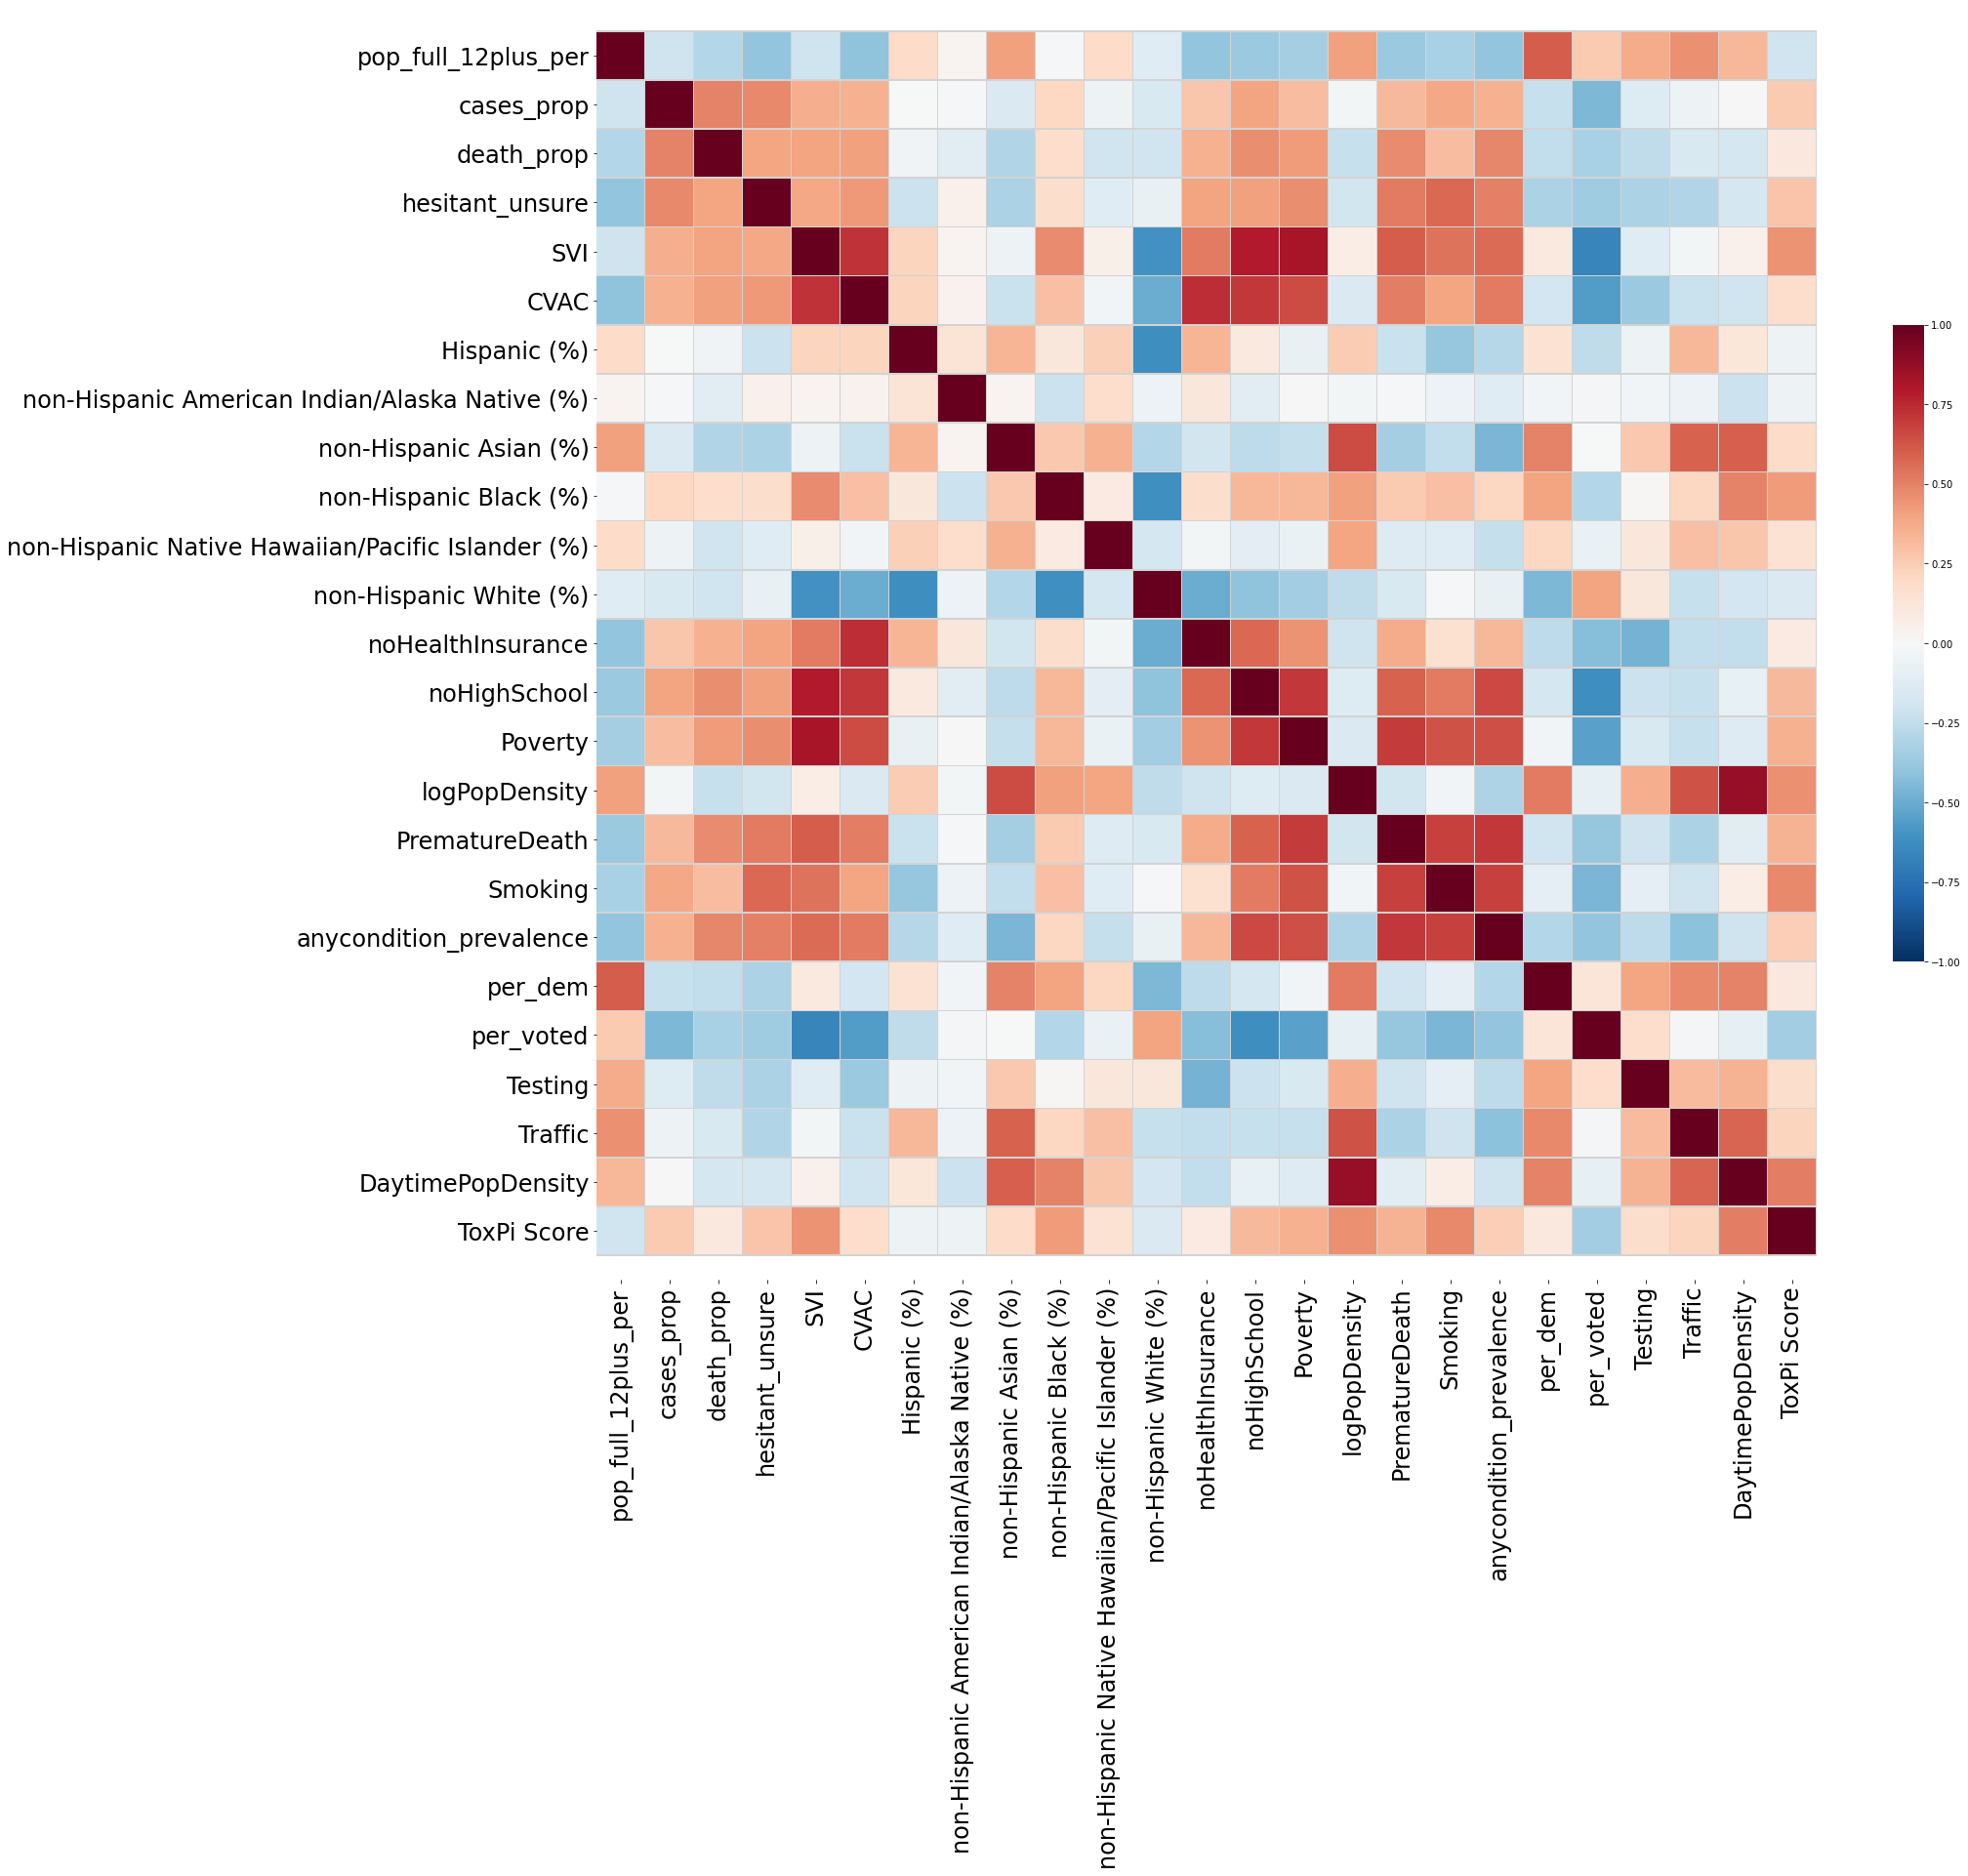

In [7]:
plt.figure(figsize = (28, 24))

full_corr_12 = df_all.select_dtypes(include = ['float64']).drop(columns = ['pop_full_18plus_per',
                               'pop_full_65plus_per']).corr(method = 'spearman')

corr_02 = full_corr_12.where(-((full_corr_12 < 0.2) & (full_corr_12 > -0.2)))

plt.figure(figsize = (28, 24))

color_map = plt.cm.get_cmap('RdBu')
reversed_col = color_map.reversed()

ax = sns.heatmap(full_corr_12, 
                      cmap = reversed_col, linewidths = 0.6,
                      cbar_kws={"shrink": 0.5},
                      vmin = -1, vmax = 1,
                      linecolor = 'lightgrey')
ax.tick_params(axis = 'both', which = 'major', labelsize = 24)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [8]:
df_all.isnull().sum()[df_all.isnull().sum() > 1]

pop_full_12plus_per     55
pop_full_18plus_per    266
pop_full_65plus_per      8
dtype: int64

### Drop `NaN` from target:

In [9]:
df = df_all[df_all['pop_full_12plus_per'].notna()]

In [10]:
df.shape

(3053, 34)

## Split data into `train`, `val` and `test` samples.

- keep `fips` for now to be able to explore, which counties were not well predicted.
- predict `pop_full_12plus_per` for now.


- Discuss: `val` sample? `test_size` = ?
- Note dropping categorical features `SVI_cat` and `CVAC_cat`

In [11]:
y = df['pop_full_12plus_per']
X_fips = df.drop(columns = ['state_abb', 'pop_full_12plus_per',
                       'pop_full_18plus_per', 'pop_full_65plus_per',
                       'SVI_cat', 'CVAC_cat'])

#### `y_test` - leave until final model has been picked.

In [12]:
X_train_val_fips, X_test_fips, y_train_val, y_test = train_test_split(X_fips, y, test_size = 0.2, random_state = 42)

In [13]:
print('test data shape:', y_test.shape)

test data shape: (611,)


#### Get a validation sample?

In [14]:
X_train_fips, X_val_fips, y_train, y_val = train_test_split(X_train_val_fips, y_train_val,
                                                           test_size = 0.2, random_state = 42)

In [15]:
print('train data shape:', y_train.shape)
print('val data shape:', y_val.shape)

train data shape: (1953,)
val data shape: (489,)


#### Drop `fips` for modelling

In [16]:
X = X_fips.drop(columns = ['fips','state', 'county'])

In [17]:
X_test = X_test_fips.drop(columns = ['fips','state', 'county'])
X_train = X_train_fips.drop(columns = ['fips','state', 'county'])
X_val = X_val_fips.drop(columns = ['fips','state', 'county'])

In [18]:
X_train.shape

(1953, 25)

## Exploring Training and Validation Data

-------
# Individual models:

---------
# Regression:

`Ridge` / `Lasso`

#### To consider:

- outliers
- transfor of rights skewed data
- optimise `lambda`(default = 1; alpha = 0 - OLS). Larger alpha specify stronger regularisation and the coefficients become more robust to collinearity. 

## OLS

In [198]:
reg = LinearRegression().fit(X_train, y_train)
y_train_reg = reg.predict(X_train)
y_val_reg = reg.predict(X_val)

In [199]:
print('Training')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_train_reg))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_train_reg)))
print('Validation')
print('Mean Absolute Error:', mean_absolute_error(y_val, y_val_reg))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_val_reg)))

Training
Mean Absolute Error: 6.209729580343862
Root Mean Squared Error: 8.564585055765754
Validation
Mean Absolute Error: 6.762987208286935
Root Mean Squared Error: 9.782617004583045


In [200]:
#Cross Validation Score using full dataset 
cross_val_score(LinearRegression(), X, y, cv=5, scoring = 'neg_mean_absolute_error').mean()

-7.714786280796216

In [201]:
coeff_df = pd.DataFrame(reg.coef_, X.columns, columns=['Coefficient'])

In [202]:
import statsmodels.api as sm
mod = sm.OLS(y_train,X_train)
fii = mod.fit()
print(fii.summary())
#p_values = fii.summary2().tables[1]['P>|t|']
#p_values

                                 OLS Regression Results                                 
Dep. Variable:     pop_full_12plus_per   R-squared (uncentered):                   0.972
Model:                             OLS   Adj. R-squared (uncentered):              0.971
Method:                  Least Squares   F-statistic:                              2658.
Date:                 Sun, 17 Oct 2021   Prob (F-statistic):                        0.00
Time:                         20:30:40   Log-Likelihood:                         -6965.5
No. Observations:                 1953   AIC:                                  1.398e+04
Df Residuals:                     1928   BIC:                                  1.412e+04
Df Model:                           25                                                  
Covariance Type:             nonrobust                                                  
                                                        coef    std err          t      P>|t|      [0.025     

- Most p-values for the regression coefficients are very close to zero:
- High p-values not signifcant are - death_prop, non-Hispanic American Indian/Alaska Native (%), non-Hispanic Asian (%) , non-Hispanic Native Hawaiian/Pacific Islander (%), non-Hispanic White (%), noHighSchool, Traffic  

### Residuals

In [203]:
residuals = y_train - y_train_reg
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -1.8445733078872034e-15


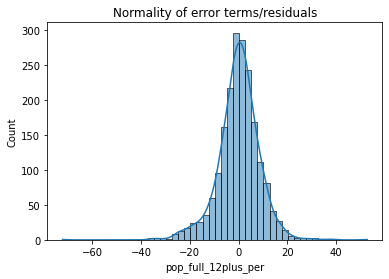

In [204]:
sns.histplot(residuals,kde=True, bins = 50)
plt.title('Normality of error terms/residuals')
plt.show()

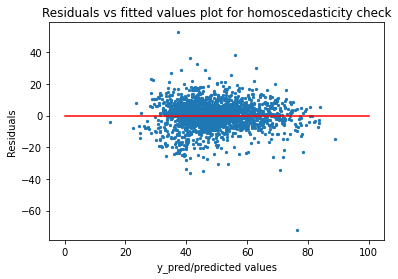

In [205]:
plt.scatter(y_train_reg,residuals, s = 5)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.plot([0,100],[0,0],color='red')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')
plt.show()

### Outliers

In [206]:
#Outliers from residuals
abs_res = abs(y_train - y_train_reg)
abs_res_sort = abs_res.sort_values(ascending = False)
abs_res_sort = abs_res_sort[abs_res_sort > 30]
abs_res_sort

1186    72.211830
1141    52.587945
2908    38.247391
720     36.436460
3003    36.125147
2982    35.144697
1771    34.139130
2990    33.642990
886     32.503660
479     30.836666
432     30.415296
271     30.226259
Name: pop_full_12plus_per, dtype: float64

In [207]:
pd.set_option('display.max_columns', None)
outlier_ind = np.array(abs_res_sort.index)
X_fips.loc[outlier_ind]

,fips,state,county,cases_prop,death_prop,hesitant_unsure,SVI,CVAC,Hispanic (%),non-Hispanic American Indian/Alaska Native (%),non-Hispanic Asian (%),non-Hispanic Black (%),non-Hispanic Native Hawaiian/Pacific Islander (%),non-Hispanic White (%),noHealthInsurance,noHighSchool,Poverty,logPopDensity,Urban_rural_code,PrematureDeath,Smoking,anycondition_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score
1186,25007,Massachusetts,Dukes County,8.314522,0.147638,0.0603,0.01,0.01,0.0364,0.0067,0.0034,0.0420,0.0000,0.8555,5.4,3.4,7.6,9.760310,5,4820.134176,0.120185,34.1,0.774652,0.738403,3029.0,28.743655,160.1,0.398342
1141,22125,Louisiana,West Feliciana Parish,9.583762,0.250514,0.2647,0.69,0.64,0.0124,0.0019,0.0061,0.4443,0.0000,0.5237,8.4,18.5,21.0,9.652973,3,8675.348637,0.218984,49.9,0.366624,0.402621,1516.0,36.925339,27.5,0.418014
2908,51740,Virginia,Portsmouth city,12.635861,0.235174,0.1402,0.80,0.34,0.0446,0.0037,0.0137,0.5224,0.0028,0.3766,14.0,14.0,18.5,11.455275,2,11128.686543,0.189833,53.0,0.694182,0.472277,2117.0,545.310607,3026.3,0.512257
720,18115,Indiana,Ohio County,13.923404,0.187234,0.1710,0.03,0.57,0.0126,0.0010,0.0044,0.0039,0.0000,0.9641,7.9,11.7,9.3,8.678461,2,7025.548828,0.167370,45.6,0.237042,0.538553,1328.0,75.129576,53.8,0.472980
3003,54091,West Virginia,Taylor County,11.877808,0.203654,0.1535,0.49,0.34,0.0101,0.0000,0.0031,0.0129,0.0000,0.9548,8.9,12.1,16.0,9.722865,5,8648.018991,0.210297,55.7,0.243262,0.442228,5523.0,6.692427,77.0,0.570305
2982,54049,West Virginia,Marion County,12.614139,0.135540,0.1535,0.49,0.24,0.0130,0.0036,0.0048,0.0349,0.0000,0.9248,8.0,10.9,16.2,10.934392,5,8592.401106,0.233256,53.3,0.345080,0.460016,5470.0,27.289174,168.2,0.630793
1771,35019,New Mexico,Guadalupe County,13.604651,0.348837,0.1453,0.95,0.67,0.7390,0.0533,0.0021,0.0057,0.0000,0.1939,10.0,22.3,22.6,8.366370,6,10238.281488,0.149326,48.3,0.563728,0.509070,2791.0,128.923943,1.5,0.454492
2990,54065,West Virginia,Morgan County,10.478640,0.201297,0.1443,0.18,0.23,0.0039,0.0068,0.0000,0.0109,0.0000,0.9527,10.5,15.0,13.0,9.791662,6,11740.395793,0.207565,50.6,0.229787,0.486189,4222.0,29.635699,65.6,0.556117
886,20065,Kansas,Graham County,12.651088,0.402901,0.2037,0.13,0.39,0.0198,0.0000,0.0175,0.0417,0.0000,0.8853,12.9,6.7,12.8,7.816820,6,12184.883130,0.151740,50.5,0.170507,0.524577,2216.0,58.546314,2.7,0.393418
479,13247,Georgia,Rockdale County,12.084140,0.237634,0.2262,0.55,0.50,0.1022,0.0009,0.0198,0.5377,0.0020,0.3172,18.9,13.1,14.1,11.417471,2,7963.337171,0.183283,50.5,0.699111,0.491562,1830.0,178.358506,688.6,0.600593


Fit model again removing 2 outliers and dropping  death_prop, non-Hispanic American Indian/Alaska Native (%), non-Hispanic Asian (%) , non-Hispanic Native Hawaiian/Pacific Islander (%), non-Hispanic White (%), noHighSchool, Traffic

In [208]:
X_train_1 = X_train.drop(['death_prop', 
                          'non-Hispanic American Indian/Alaska Native (%)',
                          'non-Hispanic Asian (%)',
                          'non-Hispanic Native Hawaiian/Pacific Islander (%)',
                          'non-Hispanic White (%)',
                          'noHighSchool', 
                          'Traffic'], axis = 1)
X_val_1 = X_val.drop(['death_prop', 
                          'non-Hispanic American Indian/Alaska Native (%)',
                          'non-Hispanic Asian (%)',
                          'non-Hispanic Native Hawaiian/Pacific Islander (%)',
                          'non-Hispanic White (%)',
                          'noHighSchool', 
                          'Traffic'], axis = 1)

reg = LinearRegression().fit(X_train_1, y_train)
y_train_reg_1 = reg.predict(X_train_1)
y_val_reg_1 = reg.predict(X_val_1)
print('Training')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_train_reg_1))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_train_reg_1)))
print('Validation')
print('Mean Absolute Error:', mean_absolute_error(y_val, y_val_reg_1))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_val_reg_1)))

Training
Mean Absolute Error: 6.227726032735287
Root Mean Squared Error: 8.602394122501854
Validation
Mean Absolute Error: 6.738516991451335
Root Mean Squared Error: 9.651784348602538


In [212]:
#Cross Validation Score using full dataset 
X_1 = X.drop(['death_prop', 
                          'non-Hispanic American Indian/Alaska Native (%)',
                          'non-Hispanic Asian (%)',
                          'non-Hispanic Native Hawaiian/Pacific Islander (%)',
                          'non-Hispanic White (%)',
                          'noHighSchool', 
                          'Traffic'], axis = 1)
cross_val_score(LinearRegression(), X_1, y, cv=5, scoring = 'neg_mean_absolute_error').mean()

-7.512220044356157

## Ridge Regression:

In [220]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [232]:
rid = Ridge(alpha = 10).fit(X_train_scaled, y_train)
y_train_rid = rid.predict(X_train_scaled)
y_val_rid = rid.predict(X_val_scaled)

In [233]:
print('Training')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_train_rid))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_train_rid)))
print('Validation')
print('Mean Absolute Error:', mean_absolute_error(y_val, y_val_rid))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_val_rid)))

Training
Mean Absolute Error: 6.206281651807851
Root Mean Squared Error: 8.565966795532395
Validation
Mean Absolute Error: 6.7562012702470255
Root Mean Squared Error: 9.783832215064932


In [235]:
random_grid = {'alpha': list(np.arange(10,10000,10))}
rid = Ridge()
rid_random = GridSearchCV(estimator = rid, param_grid= random_grid, cv = 5)
rid_random.fit(X, y)
rid_random.best_params_

{'alpha': 10}

In [236]:
random_grid = {'alpha': list(np.arange(0,10,0.1))}
rid = Ridge()
rid_random = GridSearchCV(estimator = rid, param_grid= random_grid, cv = 5)
rid_random.fit(X, y)
rid_random.best_params_

{'alpha': 1.5}

In [237]:
rid = Ridge(alpha = 1.5).fit(X_train_scaled, y_train)
y_train_rid = rid.predict(X_train_scaled)
y_val_rid = rid.predict(X_val_scaled)

In [238]:
print('Training')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_train_rid))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_train_rid)))
print('Validation')
print('Mean Absolute Error:', mean_absolute_error(y_val, y_val_rid))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_val_rid)))

Training
Mean Absolute Error: 6.2091186199142046
Root Mean Squared Error: 8.564650554127466
Validation
Mean Absolute Error: 6.761345870109177
Root Mean Squared Error: 9.782037548820174


In [239]:
cross_val_score(Ridge(alpha = 1.5), X, y, cv=5, scoring = 'neg_mean_absolute_error').mean()

-7.527484888296269

----------
## Random Forest Regression:

- No scaling of the data.
- RF might be trickier when combining categorical and continuous data, as RF will give more weight to continuous features especially in calculating the feature_importances. RF is likely to give more weight to parameters with more levels.

- optimise 
    - `n_estimators` (number of random trees), 
    - `max_features` (the number of randomly selected features in each tree, if max_features is close to the total number of features, the trees are more likely to be similar.
    - `max_depth` – the depth of each tree in the ensemble (default=None, splits until all leaves are pure).


#### Train base model prior to optimising Ho:


- overfitting! `RF_base rho: 0.964`

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF_base rho: 0.961
R2 score: 0.925
MAE: 2.610



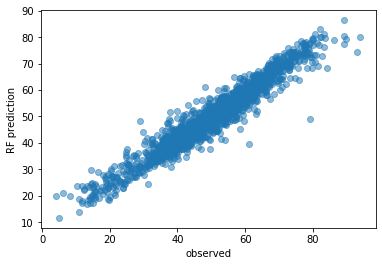

In [53]:
rf_base = RandomForestRegressor()

rf_base.fit(X_train, y_train)
y_train_rf_base = rf_base.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_rf_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_rf_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_rf_base)))
print()
plt.scatter(y_train,y_train_rf_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

### Feature importance:

In [54]:
feature_names = X_train.columns

importances = rf_base.feature_importances_

std = np.std([
    tree.feature_importances_ for tree in rf_base.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending = False)

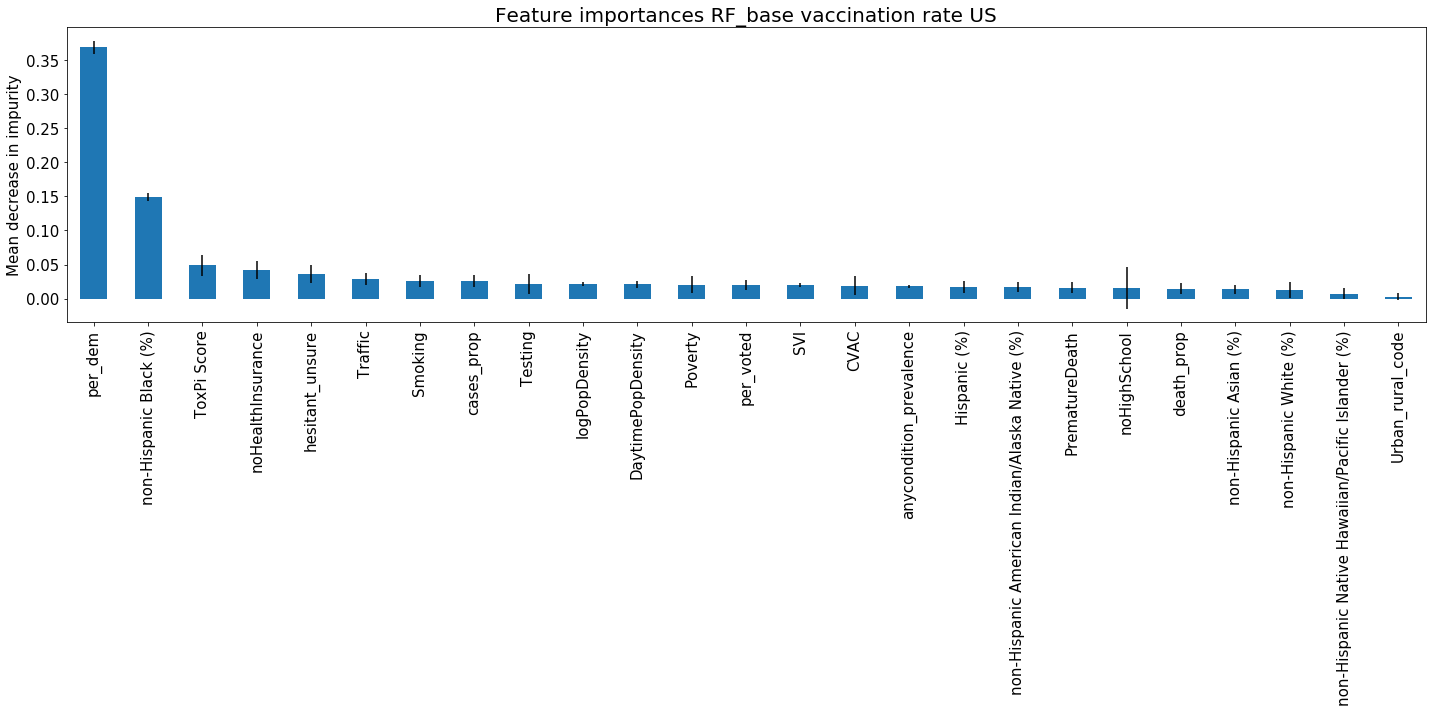

In [55]:

fig, ax = plt.subplots(figsize = (20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances RF_base vaccination rate US" , fontsize=20)

ax.set_ylabel("Mean decrease in impurity", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize = 15)

fig.tight_layout()

from sklearn.inspection import permutation_importance

result = permutation_importance(rf_base, X_train, y_train, n_repeats=5,
                                random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Hyperparam optimisation:

In [56]:
search_param = {'n_estimators': [10, 100, 500, 1000],
               'max_features':('auto', 'sqrt'),
               'max_depth': [5, 15, 20, 25]}

search = GridSearchCV(rf_base, param_grid = search_param,
                     cv = 5, scoring = 'neg_mean_absolute_error')

search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5, 15, 20, 50],
     

In [57]:
print(search.best_params_)
print(search.best_score_)

{'max_depth': 50, 'max_features': 'auto', 'n_estimators': 500}
-6.05104895033282


### Updated RandomForest:

####  `GridSearchCV` takes ~15 min to run so results are saved below:

massively overfitting still.

RF_base rho: 0.981
R2 score: 0.949
MAE: 2.207



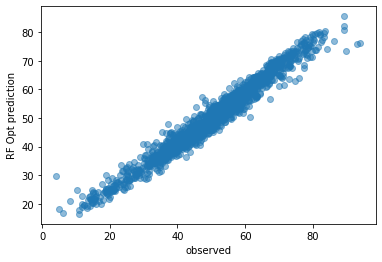

In [58]:
rf_opt = RandomForestRegressor(n_estimators = 500, max_features = 'auto', max_depth = 20)

rf_opt.fit(X_train, y_train)
y_train_rf_opt = rf_opt.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_rf_opt)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_rf_opt)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_rf_opt)))
print()
plt.scatter(y_train,y_train_rf_opt, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF Opt prediction')
plt.show()

### Validation set:

`rf_base` vs `rf_opt`

Rho: Base 0.769607, Opt 0.783472
MAE: Base 6.663620, Opt 6.221799
R2: Base 0.560249, Opt 0.577486


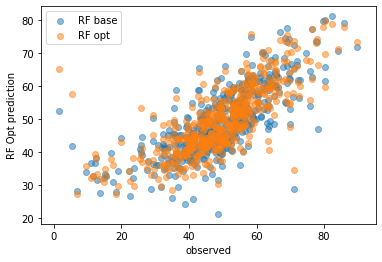

In [59]:
y_val_rf_base = rf_base.predict(X_val)
y_val_rf_opt = rf_opt.predict(X_val)


print('Rho: Base {:2f}, Opt {:2f}'.format(spearmanr(y_val,y_val_rf_base)[0],
                                     spearmanr(y_val,y_val_rf_opt)[0]))
print('MAE: Base {:2f}, Opt {:2f}'.format(mean_absolute_error(y_val,y_val_rf_base),
                                     mean_absolute_error(y_val,y_val_rf_opt)))
print('R2: Base {:2f}, Opt {:2f}'.format(r2_score(y_val,y_val_rf_base),
                                     r2_score(y_val,y_val_rf_opt)))

plt.scatter(y_val,y_val_rf_base, alpha = 0.5, label = 'RF base')
plt.scatter(y_val,y_val_rf_opt, alpha = 0.5, label = 'RF opt')
plt.xlabel('observed'), plt.ylabel('RF Opt prediction')
plt.legend()
plt.show()

### Explore counties with large errors:

#### abs(`obs` - `pred`) > 20

In [60]:
d = {'obs': y_val.values,
    'pred': y_val_rf_opt}
x_val_rf_pred = pd.DataFrame(data = d)
x_val_rf_pred['error'] = x_val_rf_pred['obs'] - x_val_rf_pred['pred']

In [61]:
X_val_fips_error = pd.concat( [X_val_fips.reset_index(drop = True), x_val_rf_pred.reset_index(drop = True)], axis=1)
X_val_fips_error.head(n = 3)

,fips,state,county,cases_prop,death_prop,hesitant_unsure,SVI,CVAC,Hispanic (%),non-Hispanic American Indian/Alaska Native (%),...,anycondition_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score,obs,pred,error
0,26001,Michigan,Alcona County,9.053340,0.374820,0.1717,0.26,0.37,0.0150,0.0058,...,50.5,0.303228,0.678904,2249.0,12.143237,13.1,0.447609,55.1,52.051297,3.048703
1,9009,Connecticut,New Haven County,12.019790,0.259021,0.0854,0.52,0.04,0.1811,0.0010,...,39.5,0.580480,0.489004,4697.0,550.060850,1362.4,0.461122,77.5,73.222780,4.277220
2,29043,Missouri,Christian County,14.269428,0.173825,0.1946,0.15,0.45,0.0295,0.0030,...,44.7,0.237644,0.528687,1831.0,65.429545,117.6,0.430476,48.6,49.923418,-1.323418


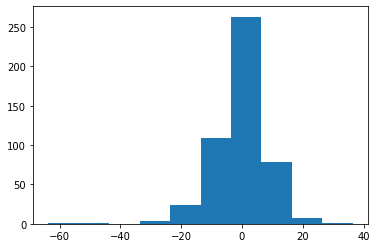

In [62]:
plt.hist(X_val_fips_error['error'])
plt.show()

In [63]:
X_val_fips_error[abs(X_val_fips_error['error']) > 20]

,fips,state,county,cases_prop,death_prop,hesitant_unsure,SVI,CVAC,Hispanic (%),non-Hispanic American Indian/Alaska Native (%),...,anycondition_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score,obs,pred,error
3,42053,Pennsylvania,Forest County,21.222575,0.317373,0.1849,0.71,0.54,0.0554,0.0004,...,49.3,0.275132,0.365117,4429.0,22.080382,14.2,0.443240,71.2,34.769600,36.430400
104,46089,South Dakota,McPherson County,12.694409,0.294241,0.1485,0.29,0.12,0.0131,0.0035,...,44.8,0.167674,0.556536,1093.0,6.134701,2.1,0.477249,12.5,38.304138,-25.804138
137,25001,Massachusetts,Barnstable County,7.902249,0.238039,0.0612,0.06,0.00,0.0310,0.0057,...,37.9,0.611967,0.705784,3690.0,65.380735,532.5,0.499337,5.5,57.643000,-52.143000
145,50005,Vermont,Caledonia County,4.947821,0.033341,0.0939,0.27,0.31,0.0160,0.0030,...,36.9,0.557301,0.539092,8242.0,52.297211,47.5,0.488079,36.1,56.360900,-20.260900
149,54105,West Virginia,Wirt County,12.867205,0.171792,0.1524,0.37,0.44,0.0047,0.0000,...,59.3,0.175650,0.455764,5566.0,0.065980,18.2,0.555453,6.7,27.466200,-20.766200
165,13187,Georgia,Lumpkin County,13.823267,0.270753,0.2076,0.43,0.65,0.0484,0.0022,...,41.2,0.201275,0.462095,1119.0,44.623691,102.6,0.542525,10.9,32.182884,-21.282884
211,13049,Georgia,Charlton County,16.039427,0.388292,0.2723,0.88,0.95,0.0837,0.0178,...,51.4,0.241900,0.341099,680.0,27.798933,12.1,0.554278,12.9,33.492939,-20.592939
217,25019,Massachusetts,Nantucket County,8.949593,0.145995,0.0603,0.03,0.01,0.0416,0.0029,...,32.8,0.717356,0.640933,3123.0,0.000000,236.8,0.379504,1.5,65.146400,-63.646400
258,28063,Mississippi,Jefferson County,13.319027,0.472103,0.2810,0.96,0.97,0.0722,0.0015,...,64.3,0.850678,0.559514,2389.0,13.027174,13.7,0.493065,69.8,47.618000,22.182000
277,13055,Georgia,Chattooga County,17.681230,0.367098,0.2414,0.93,0.92,0.0515,0.0014,...,53.5,0.184478,0.405422,1763.0,63.186996,73.0,0.632376,15.0,35.061610,-20.061610


In [64]:
X_val_fips_error[abs(X_val_fips_error['error']) > 60]

,fips,state,county,cases_prop,death_prop,hesitant_unsure,SVI,CVAC,Hispanic (%),non-Hispanic American Indian/Alaska Native (%),...,anycondition_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score,obs,pred,error
217,25019,Massachusetts,Nantucket County,8.949593,0.145995,0.0603,0.03,0.01,0.0416,0.0029,...,32.8,0.717356,0.640933,3123.0,0.0,236.8,0.379504,1.5,65.1464,-63.6464


In [65]:
df_all[df_all['fips'] == 25019]

,fips,state,county,state_abb,pop_full_12plus_per,pop_full_18plus_per,pop_full_65plus_per,cases_prop,death_prop,hesitant_unsure,...,Urban_rural_code,PrematureDeath,Smoking,anycondition_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score
1192,25019,Massachusetts,Nantucket County,MA,1.5,1.6,2.9,8.949593,0.145995,0.0603,...,6,4173.372859,0.139488,32.8,0.717356,0.640933,3123.0,0.0,236.8,0.379504


-----------------
## ExtraTreesRegressor

RF_base rho: 1.000
R2 score: 1.000
MAE: 0.000



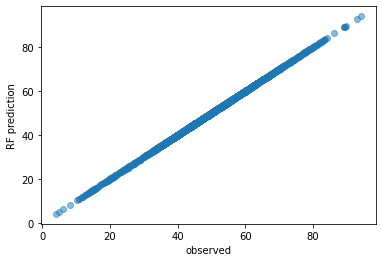

In [241]:
etr_base = ExtraTreesRegressor()

etr_base.fit(X_train, y_train)
y_train_etr_base = etr_base.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_etr_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_etr_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_etr_base)))
print()
plt.scatter(y_train,y_train_etr_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

RF_base rho: 0.806
R2 score: 0.616
MAE: 5.901



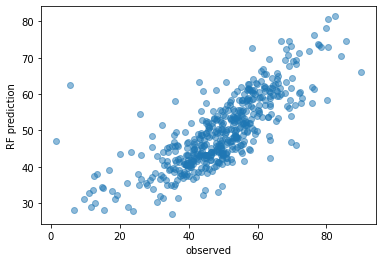

In [242]:
etr_base.fit(X_train, y_train)
y_val_etr_base = etr_base.predict(X_val)

print('RF_base rho: {:.3f}'.format(spearmanr(y_val,y_val_etr_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_val,y_val_etr_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_val,y_val_etr_base)))
print()
plt.scatter(y_val,y_val_etr_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

In [250]:
print('Training')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_train_etr_base))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_train_etr_base)))
print('Validation')
print('Mean Absolute Error:', mean_absolute_error(y_val, y_val_etr_base))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_val_etr_base)))

Training
Mean Absolute Error: 5.763109168360403e-14
Root Mean Squared Error: 7.181837912078782e-14
Validation
Mean Absolute Error: 5.901012269938652
Root Mean Squared Error: 8.41538448598962


In [251]:
cross_val_score(etr_base, X, y, cv=5, scoring = 'neg_mean_absolute_error').mean()

-7.550279011563951

In [246]:
random_grid = {'max_depth': [5, 15, 20, 25, None],
               'n_estimators': [10, 100, 500, 1000],
              'max_features':('auto', 'sqrt', 'log2')}
etr = ExtraTreesRegressor()
etr_random = GridSearchCV(estimator = etr, param_grid= random_grid, cv = 5)
etr_random.fit(X, y)
etr_random.best_params_

{'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 1000}

In [257]:
etr = ExtraTreesRegressor(max_depth =  25, max_features = 'sqrt', n_estimators = 1000)
etr.fit(X_train, y_train)
y_train_etr = etr.predict(X_train)
y_val_etr = etr.predict(X_val)
print('Training')
print('Mean Absolute Error:', mean_absolute_error(y_train,y_train_etr))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train,y_train_etr)))
print('Validation')
print('Mean Absolute Error:', mean_absolute_error(y_val,y_val_etr))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val,y_val_etr)))

Training
Mean Absolute Error: 0.06782094072885407
Root Mean Squared Error: 0.11934502901394999
Validation
Mean Absolute Error: 6.016522188149723
Root Mean Squared Error: 8.650662222788322


In [253]:
cross_val_score(etr, X, y, cv=5, scoring = 'neg_mean_absolute_error').mean()

-7.56830453259794

In [281]:
random_grid = {'max_depth': [5, 15, 20, 25, None],
               'n_estimators': [1000],
              'max_features': ['sqrt'], 
              'min_samples_leaf': [1, 2, 5, 10]}
etr = ExtraTreesRegressor()
etr_random = GridSearchCV(estimator = etr, param_grid= random_grid, cv = 5)
etr_random.fit(X, y)
etr_random.best_params_

{'max_depth': 25,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 1000}

In [291]:
etr = ExtraTreesRegressor(max_depth =  25, max_features = 'sqrt', n_estimators = 1000, min_samples_split = 2)
etr.fit(X_train, y_train)
y_train_etr = etr.predict(X_train)
y_val_etr = etr.predict(X_val)
print('Training')
print('Mean Absolute Error:', mean_absolute_error(y_train,y_train_etr))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train,y_train_etr)))
print('Validation')
print('Mean Absolute Error:', mean_absolute_error(y_val,y_val_etr))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val,y_val_etr)))

Training
Mean Absolute Error: 0.07389442848344377
Root Mean Squared Error: 0.13212052886923256
Validation
Mean Absolute Error: 5.99836090797994
Root Mean Squared Error: 8.640408957937616


In [292]:
cross_val_score(etr, X, y, cv=5, scoring = 'neg_mean_absolute_error').mean()

-7.5668113015064495

In [294]:
feature_names = X_train.columns
importances = etr.feature_importances_

std = np.std([
    tree.feature_importances_ for tree in etr.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending = False)

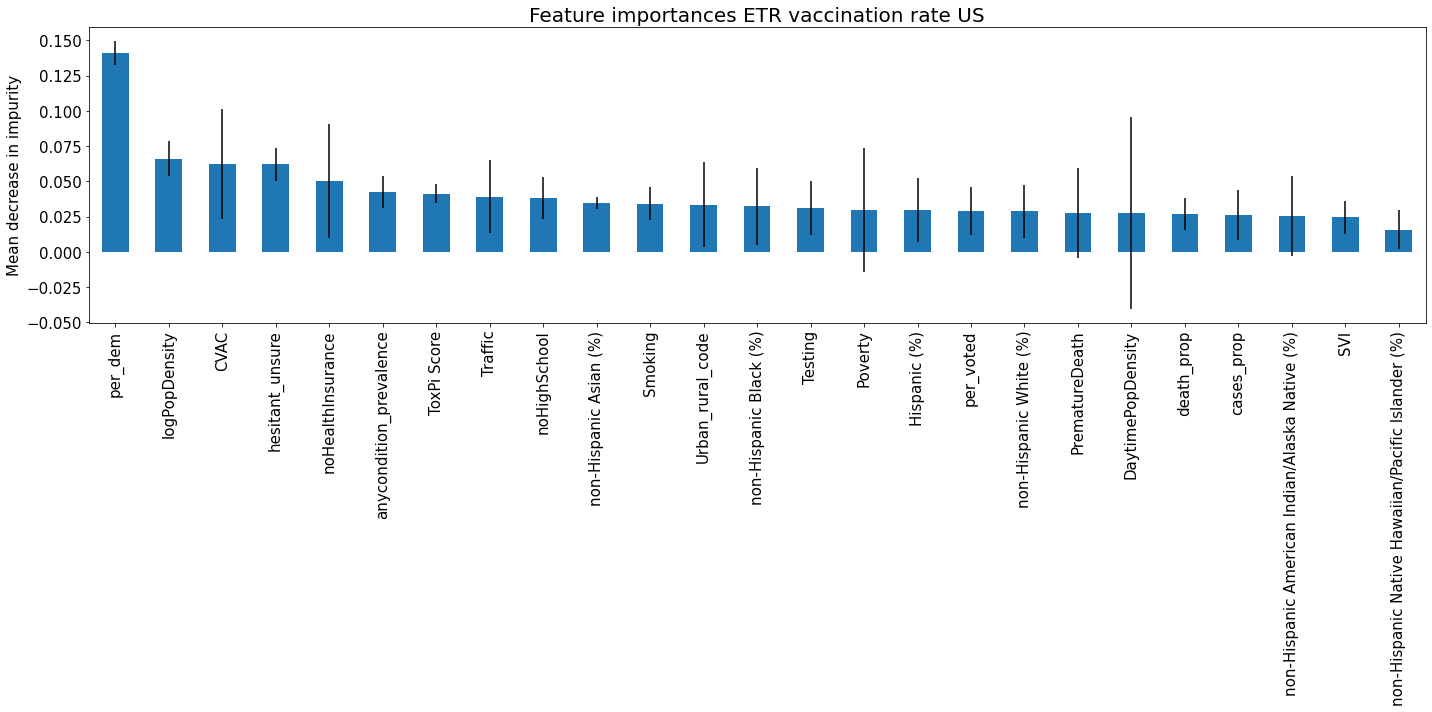

In [296]:
fig, ax = plt.subplots(figsize = (20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances ETR vaccination rate US" , fontsize=20)

ax.set_ylabel("Mean decrease in impurity", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize = 15)

fig.tight_layout()

## AdaBoostRegressor

In [258]:
abr = AdaBoostRegressor()

abr.fit(X_train, y_train)
y_train_abr = abr.predict(X_train)
y_val_abr = abr.predict(X_val)

print('Training')
print('Mean Absolute Error:', mean_absolute_error(y_train,y_train_abr))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train,y_train_abr)))
print('Validation')
print('Mean Absolute Error:', mean_absolute_error(y_val,y_val_abr))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val,y_val_abr)))

Training
Mean Absolute Error: 6.803596757763983
Root Mean Squared Error: 8.463627285384565
Validation
Mean Absolute Error: 7.270541759994659
Root Mean Squared Error: 9.77440185973145


In [274]:
parameters = {'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}
abr = AdaBoostRegressor()
abr_random = GridSearchCV(abr, parameters,cv=5,scoring='neg_mean_absolute_error',n_jobs=-1)
abr_random.fit(X, y)
abr_random.best_params_

{'learning_rate': 0.01, 'n_estimators': 10}

In [277]:
abr = AdaBoostRegressor(learning_rate = 0.01, n_estimators = 10)

abr.fit(X_train, y_train)
y_train_abr = abr.predict(X_train)
y_val_abr = abr.predict(X_val)

print('Training')
print('Mean Absolute Error:', mean_absolute_error(y_train,y_train_abr))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train,y_train_abr)))
print('Validation')
print('Mean Absolute Error:', mean_absolute_error(y_val,y_val_abr))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val,y_val_abr)))

Training
Mean Absolute Error: 7.018717811422086
Root Mean Squared Error: 9.57313232728809
Validation
Mean Absolute Error: 7.491142683286727
Root Mean Squared Error: 10.604077679014638


# Final Model Prediction - refer to ml_model notebook

In [19]:
X_train_val = X_train_val_fips.drop(columns = ['fips','state', 'county'])

In [20]:
etr_opt = ExtraTreesRegressor(n_estimators = 500, max_features = 'auto', max_depth = 15, 
                              min_samples_leaf = 3)
etr_opt.fit(X_train_val, y_train_val)
y_t = etr_opt.predict(X_test)

print('Rho: {:2f}'.format(spearmanr(y_test,y_t)[0]))
print('MAE: {:2f}'.format(mean_absolute_error(y_test,y_t)))
print('R2: {:2f},'.format(r2_score(y_test,y_t)))
print('RMSE: {:2f}'.format(np.sqrt(mean_squared_error(y_test,y_t))))

Rho: 0.814346
MAE: 6.100482
R2: 0.653604,
RMSE: 8.460337


In [24]:
mapping = {'pop_full_12plus_per': 'Fully vaccinated 12yo+ (%)',
          'cases_prop': 'Covid-19 infection cases (%)',
          'death_prop': 'Covid-19 related deaths (%)',
          'hesitant_unsure': 'hesitant or unsure about vaccination (%)',
          'noHealthInsurance': 'no Health Insurance (%)',
          'noHighSchool': 'no High schools education (25yo+) (%)',
          'Poverty': 'living in poverty (%)',
          'logPopDensity': 'Population Density (log)',
          'anycondition_prevalence': 'Prevalence medical conditions',
          'per_dem': 'Democratic voters 2020 (%)',
          'per_voted': 'voted in 2020 (%)',
          'ToxPi Score': 'PVI'}
X_train_val = X_train_val.rename(columns = mapping)
X_test = X_test.rename(columns = mapping)

# Permutation Importance on final model

Permutation importances can be computed either on the training set or on a held-out testing or validation set. Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. Features that are important on the training set but not on the held-out set might cause the model to overfit.

In [25]:
from sklearn.inspection import permutation_importance

### On Test Set

In [26]:
etr_opt = ExtraTreesRegressor(n_estimators = 500, max_features = 'auto', max_depth = 15, 
                              min_samples_leaf = 3)
etr_opt.fit(X_train_val, y_train_val)

result = permutation_importance(etr_opt, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

In [27]:
sorted_idx

array([ 9, 23,  3,  7,  0, 22, 15,  1, 20, 16,  5, 13, 12, 10, 18, 21,  6,
       17, 14,  4, 11,  2,  8, 24, 19])

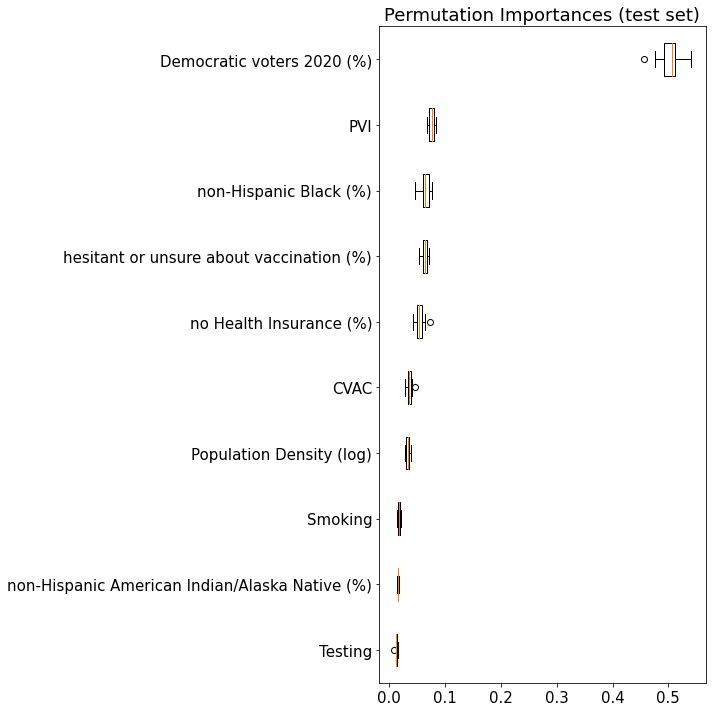

In [32]:
sorted_idx_10 = sorted_idx[-10:]

plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx_10].T,
           vert=False, labels=X_test.columns[sorted_idx_10])
ax.set_title("Permutation Importances (test set)", fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.tight_layout()
plt.savefig('../data/plots/' + 'perm_imp_test.png', dpi = 300)
plt.show()

### On Training data 

In [29]:
result_1 = permutation_importance(etr_opt, X_train_val, y_train_val, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx_1 = result_1.importances_mean.argsort()

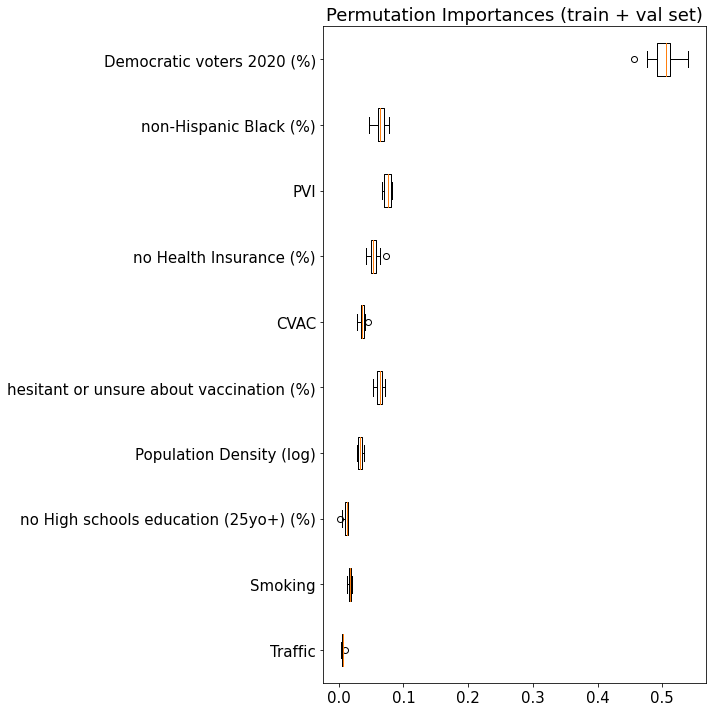

In [30]:
sorted_idx_1_10 = sorted_idx_1[-10:]

plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx_1_10].T,
           vert=False, labels=X_test.columns[sorted_idx_1_10])
ax.set_title("Permutation Importances (train + val set)", fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=15)
fig.tight_layout()
plt.savefig('../data/plots/' + 'perm_imp_train_val.png', dpi = 300)
plt.show()

## SHAP on test set

If a feature has medium permutation importance, that could mean it has a large effect for a few predictions, but no effect in general, or a medium effect for all predictions.
SHAP summary plots give us a birds-eye view of feature importance and what is driving it. 

etr_opt contains data about the training_val set that it was built on, so TreeExplainer uses that for computing conditional expectations. You pass to explainer.shap_values whatever samples you want to explain - we start with test set

In [31]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(etr_opt)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

- 611: SHAP values for every datapoint 
- 25: SHAP value contributions for every feature

In [33]:
shap_values.shape

(611, 25)

### Interactive Plot

In blue, we have negative Shap values that show everything that pushes the sales value in the negative direction. While the Shap value in red represents everything that pushes it towards a positive direction.

Stacked SHAP explanations clustered by explanation similarity. Each position on the x-axis is an instance of the data. Red SHAP values increase the prediction, blue values decrease it. A cluster stands out:

SHAP clustering works by clustering on Shapley values of each instance. This means that you cluster instances by explanation similarity. All SHAP values have the same unit – the unit of the prediction space. You can use any clustering method. The following example uses hierarchical agglomerative clustering to order the instances.

The plot consists of many force plots, each of which explains the prediction of an instance. We rotate the force plots vertically and place them side by side according to their clustering similarity.

In [65]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

This shows the Shap values on the x-axis. Here, all the values on the left represent the observations that shift the predicted value in the negative direction while the points on the right contribute to shifting the prediction in a positive direction. All the features are on the left y-axis.m

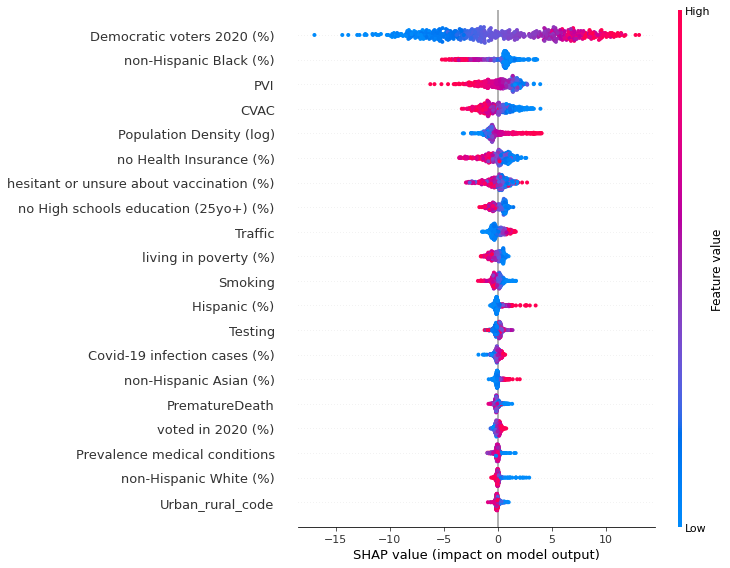

In [62]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, show=False)
plt.savefig('../data/plots/' + 'shap_summary_plot.png', bbox_inches='tight')

most influential features based on SHAP contributions are per_dem,ToxPi Score non Hispanic Black

In [40]:
X_test.columns

Index(['Covid-19 infection cases (%)', 'Covid-19 related deaths (%)',
       'hesitant or unsure about vaccination (%)', 'SVI', 'CVAC',
       'Hispanic (%)', 'non-Hispanic American Indian/Alaska Native (%)',
       'non-Hispanic Asian (%)', 'non-Hispanic Black (%)',
       'non-Hispanic Native Hawaiian/Pacific Islander (%)',
       'non-Hispanic White (%)', 'no Health Insurance (%)',
       'no High schools education (25yo+) (%)', 'living in poverty (%)',
       'Population Density (log)', 'Urban_rural_code', 'PrematureDeath',
       'Smoking', 'Prevalence medical conditions',
       'Democratic voters 2020 (%)', 'voted in 2020 (%)', 'Testing', 'Traffic',
       'DaytimePopDensity', 'PVI'],
      dtype='object')

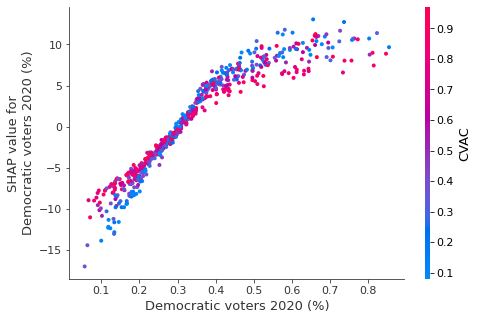

In [50]:
shap.dependence_plot('Democratic voters 2020 (%)', shap_values, X_test, show = False)
plt.savefig('../data/plots/' + 'SHAP_interaction_plot1.png', dpi = 300)

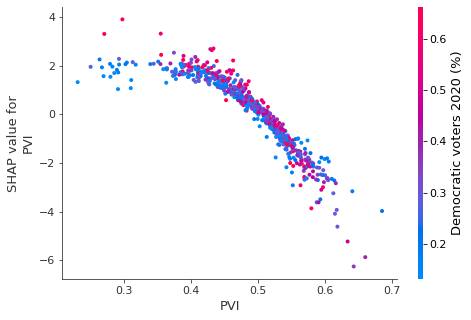

In [51]:
shap.dependence_plot("PVI", shap_values, X_test, show = False)
plt.savefig('../data/plots/' + 'SHAP_interaction_plot2.png', dpi = 300)

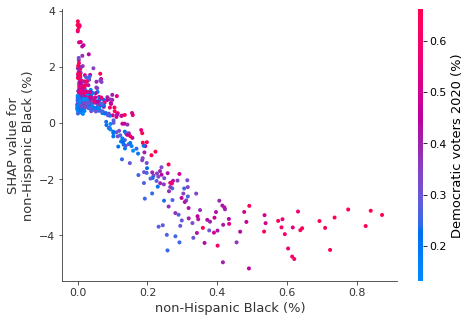

In [52]:
shap.dependence_plot("non-Hispanic Black (%)", shap_values, X_test, interaction_index = 'Democratic voters 2020 (%)',
                    show = False)
plt.savefig('../data/plots/' + 'SHAP_interaction_plot3.png', dpi = 300)

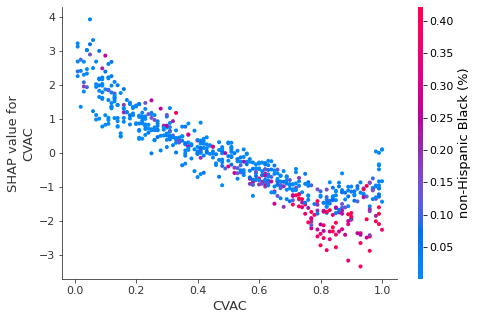

In [53]:
shap.dependence_plot("CVAC", shap_values, X_test, show = False)
plt.savefig('../data/plots/' + 'SHAP_interaction_plot4.png', dpi = 300)